--- INICIANDO EJECUCIÓN DEL PROYECTO ---
>> Datos cargados correctamente.

[CALIDAD DE DATOS] Revisión inicial:
 - Total de valores nulos encontrados: 1759
 - Total de filas duplicadas: 0
 - Dimensiones finales tras limpieza: (299, 16)

[PRE-PROCESAMIENTO] Transformando variables de texto a números...
 - Variable objetivo 'num' binarizada (0=Sano, 1=Enfermo).


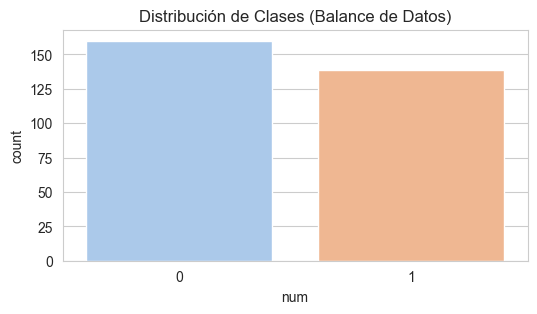


[MODELO] Precisión (Accuracy) en Test Set: 0.85

[XAI - TÉCNICA 1] Calculando Permutation Importance...


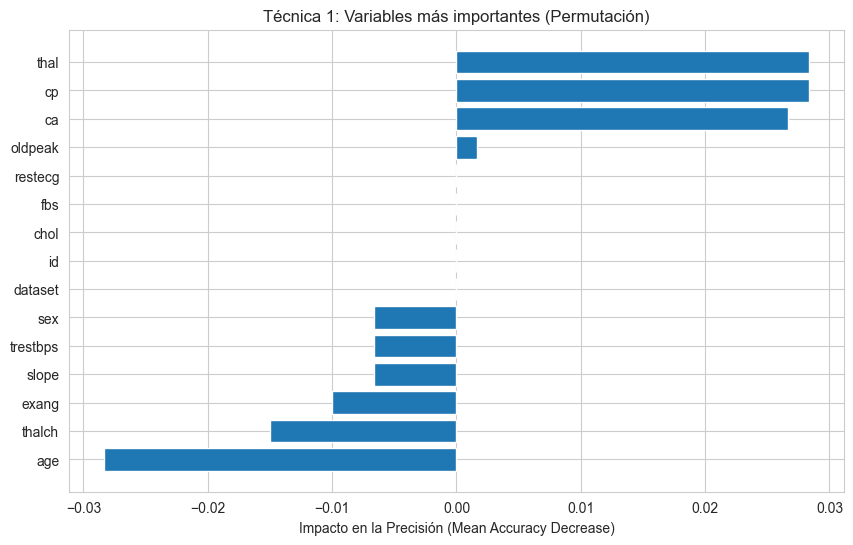


[XAI - TÉCNICA 2] Calculando valores SHAP...


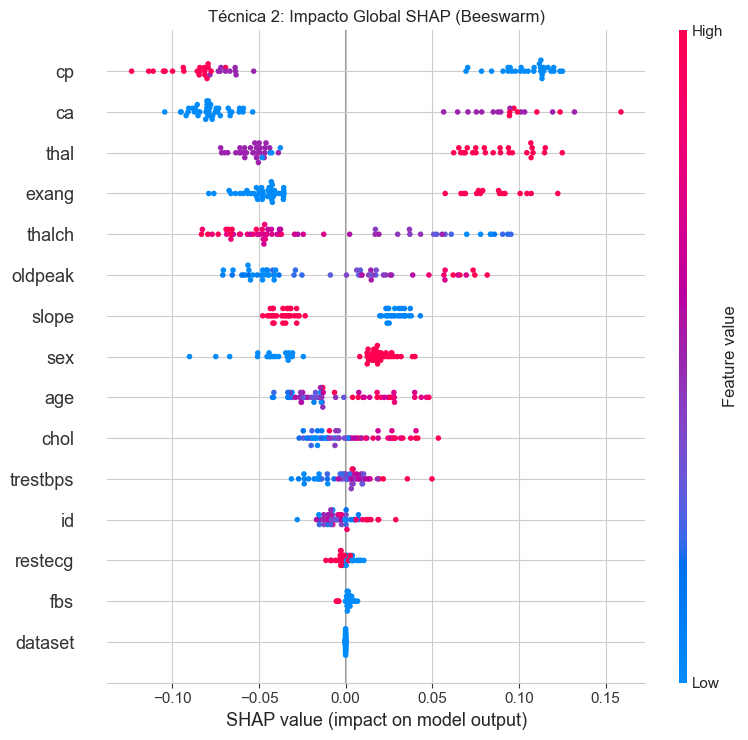


[XAI - CASO INDIVIDUAL] Analizando al Paciente #0 del Test Set...
 -> El modelo predice: ENFERMEDAD


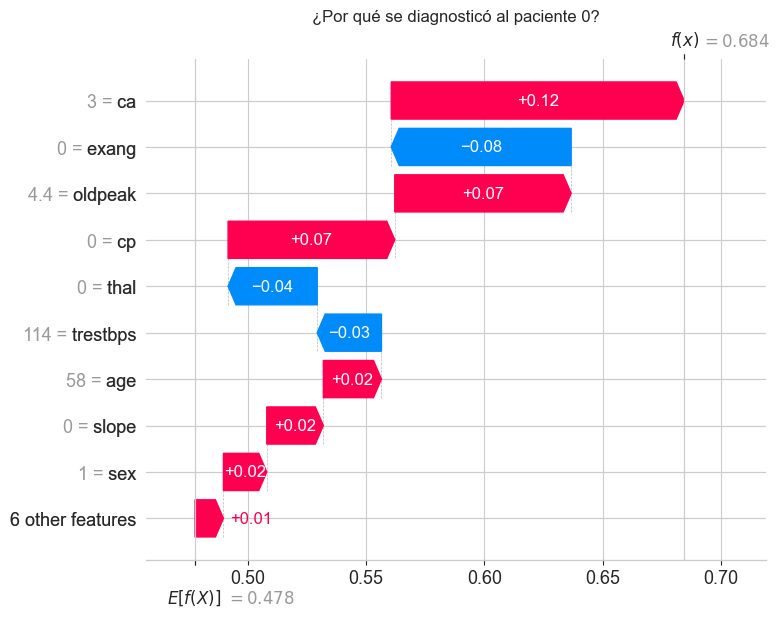


[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...


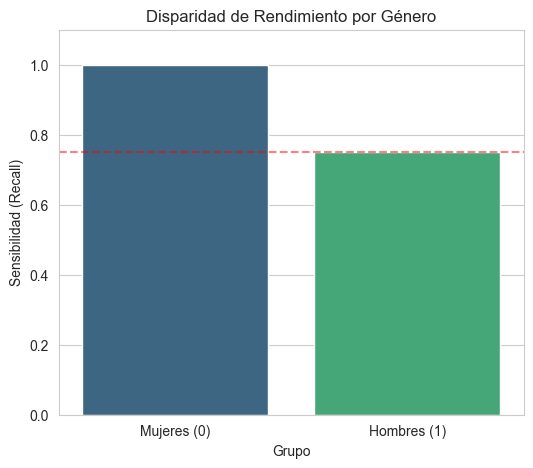

 -> Sensibilidad en Mujeres: 1.00
 -> Sensibilidad en Hombres: 0.75

[CONCLUSIÓN ÉTICA] Diferencia de rendimiento: 0.25
ALERTA: Existe un sesgo significativo. El modelo no es justo.
Esto representa un riesgo ético grave si se implementa en hospitales.

--- FIN DEL PROCESO ---


In [2]:
# =============================================================================
# PROYECTO FINAL: XAI, ÉTICA Y CALIDAD EN ML
# Dataset: Heart Disease UCI
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configuración visual para gráficos profesionales
sns.set_style("whitegrid")
plt.rcParams.update({'figure.max_open_warning': 0})

print("--- INICIANDO EJECUCIÓN DEL PROYECTO ---")

# =============================================================================
# 1. CARGA DE DATOS Y ANÁLISIS DE CALIDAD (Rúbrica: Calidad de Datos)
# =============================================================================
# URL del dataset. Usamos una versión que suele contener strings para demostrar limpieza.
url = "heart_disease_uci.csv" 
# Si falla localmente, intenta usar esta URL directa de respaldo:
# url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/heart.csv"

try:
    df = pd.read_csv(url)
    print(">> Datos cargados correctamente.")
except:
    print(">> Error cargando archivo local. Asegúrate de que el .csv esté en la carpeta.")
    # Creamos un dummy dataframe por si acaso falla la carga para que no rompa el script al copiar
    raise SystemExit("Deteniendo ejecución: No se encontró el archivo csv.")

# --- AUDITORÍA DE CALIDAD DE DATOS ---
print("\n[CALIDAD DE DATOS] Revisión inicial:")
nulos = df.isnull().sum().sum()
duplicados = df.duplicated().sum()
print(f" - Total de valores nulos encontrados: {nulos}")
print(f" - Total de filas duplicadas: {duplicados}")

# Limpieza: Eliminamos nulos para garantizar la estabilidad del modelo
df_clean = df.dropna().drop_duplicates()
print(f" - Dimensiones finales tras limpieza: {df_clean.shape}")

# =============================================================================
# 2. PRE-PROCESAMIENTO Y CODIFICACIÓN
# =============================================================================
print("\n[PRE-PROCESAMIENTO] Transformando variables de texto a números...")

# Detectamos columnas de texto (ej. 'Male', 'Angina')
cat_columns = df_clean.select_dtypes(include=['object']).columns

# Aplicamos LabelEncoder (Convierte texto a 0, 1, 2...)
# Guardamos los encoders por si necesitamos revertir la traducción luego
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    label_encoders[col] = le

# Normalizamos nombres de columnas a minúsculas
df_clean.columns = [c.lower() for c in df_clean.columns]

# --- DEFINICIÓN DEL OBJETIVO (TARGET) ---
# El dataset suele llamar al target 'num' o 'target'. Lo estandarizamos.
target_col = 'num' if 'num' in df_clean.columns else 'target'
if target_col not in df_clean.columns: target_col = df_clean.columns[-1]

# Binarización: El problema original tiene grados 0-4. 
# Lo simplificamos a: 0 (Sano) vs 1 (Cualquier grado de enfermedad)
df_clean[target_col] = df_clean[target_col].apply(lambda x: 1 if x > 0 else 0)

print(f" - Variable objetivo '{target_col}' binarizada (0=Sano, 1=Enfermo).")

# Visualización de balance (Importante para justificar métricas)
plt.figure(figsize=(6, 3))
sns.countplot(x=target_col, data=df_clean, palette='pastel', hue=target_col, legend=False)
plt.title("Distribución de Clases (Balance de Datos)")
plt.show()

# =============================================================================
# 3. ENTRENAMIENTO DEL MODELO (Rúbrica: Modelo Supervisado)
# =============================================================================
X = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

# División 80% Entrenamiento / 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo: Random Forest Classifier
# Justificación: Maneja bien relaciones no lineales y es ideal para XAI con SHAP.
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

acc = accuracy_score(y_test, model.predict(X_test))
print(f"\n[MODELO] Precisión (Accuracy) en Test Set: {acc:.2f}")

# =============================================================================
# 4. TÉCNICA XAI 1: PERMUTATION IMPORTANCE (Rúbrica: Técnica A)
# =============================================================================
# Esta técnica responde: "¿Qué tanto cae la precisión si desordeno una variable?"
# Es excelente para comparar con SHAP.
print("\n[XAI - TÉCNICA 1] Calculando Permutation Importance...")

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Impacto en la Precisión (Mean Accuracy Decrease)")
plt.title("Técnica 1: Variables más importantes (Permutación)")
plt.show()

# =============================================================================
# 5. TÉCNICA XAI 2: SHAP (Rúbrica: Técnica B + Explicación Individual)
# =============================================================================
print("\n[XAI - TÉCNICA 2] Calculando valores SHAP...")

explainer = shap.TreeExplainer(model)
# Obtención robusta de valores (corrige el error de dimensiones listas vs arrays)
shap_values_raw = explainer.shap_values(X_test)

if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1] # Formato lista (antiguo)
elif len(np.array(shap_values_raw).shape) == 3:
    shap_values = shap_values_raw[:, :, 1] # Formato array 3D (nuevo)
else:
    shap_values = shap_values_raw # Formato binario

# --- VISUALIZACIÓN GLOBAL (Summary Plot) ---
# Muestra impacto positivo/negativo de cada variable
plt.figure()
plt.title("Técnica 2: Impacto Global SHAP (Beeswarm)")
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.show()

# --- VISUALIZACIÓN LOCAL (Caso Individual) ---
# Rúbrica: "Explicaciones individuales de predicciones concretas"
print("\n[XAI - CASO INDIVIDUAL] Analizando al Paciente #0 del Test Set...")

# Usamos la API de explicación completa para waterfall plot
explanation = explainer(X_test)
# Ajuste de dimensión para waterfall
if len(explanation.shape) == 3:
    explanation_patient = explanation[0, :, 1] # Paciente 0, Clase 1
else:
    explanation_patient = explanation[0]

pred_val = model.predict(X_test.iloc[[0]])[0]
print(f" -> El modelo predice: {'ENFERMEDAD' if pred_val==1 else 'SANO'}")

plt.figure()
shap.plots.waterfall(explanation_patient, show=False)
plt.title(f"¿Por qué se diagnosticó al paciente 0?", fontsize=12)
plt.show()

# =============================================================================
# 6. ANÁLISIS ÉTICO Y DE SESGOS (Rúbrica: Reflexión Ética)
# =============================================================================
print("\n[ÉTICA] Auditoría de Sesgo Algorítmico (Hombres vs Mujeres)...")

# Identificar columna de sexo. Asumimos 'sex'. 
# Si usamos LabelEncoder: 0 suele ser Female, 1 suele ser Male (orden alfabético).
if 'sex' in X_test.columns:
    # Separamos los grupos
    mask_female = X_test['sex'] == 0
    mask_male = X_test['sex'] == 1
    
    # Calculamos Sensibilidad (Recall): Capacidad de detectar la enfermedad cuando existe.
    # Es la métrica más importante en medicina (evitar falsos negativos).
    rec_female = recall_score(y_test[mask_female], model.predict(X_test[mask_female]))
    rec_male = recall_score(y_test[mask_male], model.predict(X_test[mask_male]))
    
    # DataFrame para el gráfico
    bias_data = pd.DataFrame({
        'Grupo': ['Mujeres (0)', 'Hombres (1)'],
        'Sensibilidad (Recall)': [rec_female, rec_male]
    })
    
    # Visualización de la disparidad
    plt.figure(figsize=(6, 5))
    sns.barplot(x='Grupo', y='Sensibilidad (Recall)', data=bias_data, palette='viridis', hue="Grupo", legend=False)
    plt.title("Disparidad de Rendimiento por Género")
    plt.ylim(0, 1.1)
    plt.axhline(y=rec_male, color='r', linestyle='--', alpha=0.5)
    plt.show()
    
    print(f" -> Sensibilidad en Mujeres: {rec_female:.2f}")
    print(f" -> Sensibilidad en Hombres: {rec_male:.2f}")
    
    diff = abs(rec_female - rec_male)
    print(f"\n[CONCLUSIÓN ÉTICA] Diferencia de rendimiento: {diff:.2f}")
    if diff > 0.1:
        print("ALERTA: Existe un sesgo significativo. El modelo no es justo.")
        print("Esto representa un riesgo ético grave si se implementa en hospitales.")
    else:
        print("El modelo parece equilibrado, aunque se requiere validación externa.")
else:
    print("No se encontró la columna 'sex' para realizar el análisis ético.")

print("\n--- FIN DEL PROCESO ---")